# Example-14: Heteroclinic tangle (Henon mapping)

In [1]:
# In this example hyperbolic manifolds for several different chains are computed in the vicinity of stabily boundary
# Heteroclinic tangle formation is illustrated

In [2]:
# Import

import numpy

import jax
from jax import jit
from jax import vmap

# Test symplectic mapping and corresponding inverse

from tohubohu.util import forward2D
from tohubohu.util import inverse2D

# REM factory

from tohubohu import rem

# Fixed point

from tohubohu import iterate
from tohubohu import prime
from tohubohu import unique
from tohubohu import chain
from tohubohu import monodromy
from tohubohu import combine
from tohubohu import classify
from tohubohu import manifold

# Iteration

from tohubohu import nest
from tohubohu import nest_list

# Plotting

from matplotlib import pyplot as plt
from matplotlib import colormaps

cmap = colormaps.get_cmap('viridis')
cmap.set_bad(color='lightgray')

In [3]:
# Set data type

jax.config.update("jax_enable_x64", True)

In [4]:
# Set device

device, *_ = jax.devices('cpu')
jax.config.update('jax_default_device', device)

In [5]:
# Set initial grid

n = 1001

qs = jax.numpy.linspace(-0.75, 1.00, n)
ps = jax.numpy.linspace(-0.75, 1.00, n)
xs = jax.numpy.stack(jax.numpy.meshgrid(qs, ps, indexing='ij')).swapaxes(-1, 0).reshape(n*n, -1)
xs.shape

(1002001, 2)

In [6]:
# Set indicator

fn = jit(rem(2**12, forward2D, inverse2D))

x = jax.numpy.array([0.00, 0.00])
k = jax.numpy.array([0.46, 0.00])

fn(x, k) ;

In [7]:
%%time

# Map indicator over a grid

out = jit(vmap(fn, (0, None)))(xs, k).block_until_ready()

CPU times: user 18.2 s, sys: 280 ms, total: 18.5 s
Wall time: 4.71 s


In [8]:
# Winsorize data

data = numpy.log10(1.0E-16 + numpy.array(out.tolist()))
data[data < -15.0] = -15.0
data[data > 0.0] = 0.0
data = data.reshape(n, n)

In [9]:
# Set symmetry lines

def diagonal(q, k):
    w, s = k
    return q

def force(q, k):
    w, s = k
    return 0.5*(w*q + q**2 + s*q**3)

In [10]:
# Set initial points for fixed point computation (for each line)

size = 256
qs = jax.numpy.linspace(-1.0, 1.0, size)
xs = jax.numpy.vstack([jax.numpy.stack([qs, diagonal(qs, k)]).T, jax.numpy.stack([qs, force(qs, k)]).T])

In [11]:
# Compute fixed points and chains for several selected orders

limit = 32
orders = [1, 5, 16, 21, 26]

table_points = []
table_chains = []

for order in orders:

    # Map over intials and remove nans
    
    solver = jit(vmap(iterate(limit, forward2D, order=order), (0, None)))
    points = solver(xs, k)
    points = points[~jax.numpy.any(jax.numpy.isnan(points), -1)]
    
    # Prime period
    
    mask = jit(vmap(prime(forward2D, order=order, rtol=1.0E-12, atol=1.0E-12), (0, None)))(points, k)
    points = points[mask]

    # Unique
    
    mask = unique(order, forward2D, points, k, tol=1.0E-6)
    points = points[mask]
    
    # Chains
    
    # chains = jax.numpy.vstack(jit(vmap(chain(order, forward2D), (0, None)))(points, k))
    chains = jit(vmap(chain(order, forward2D), (0, None)))(points, k)

    # Append result
    
    table_points.append(points)
    table_chains.append(chains)

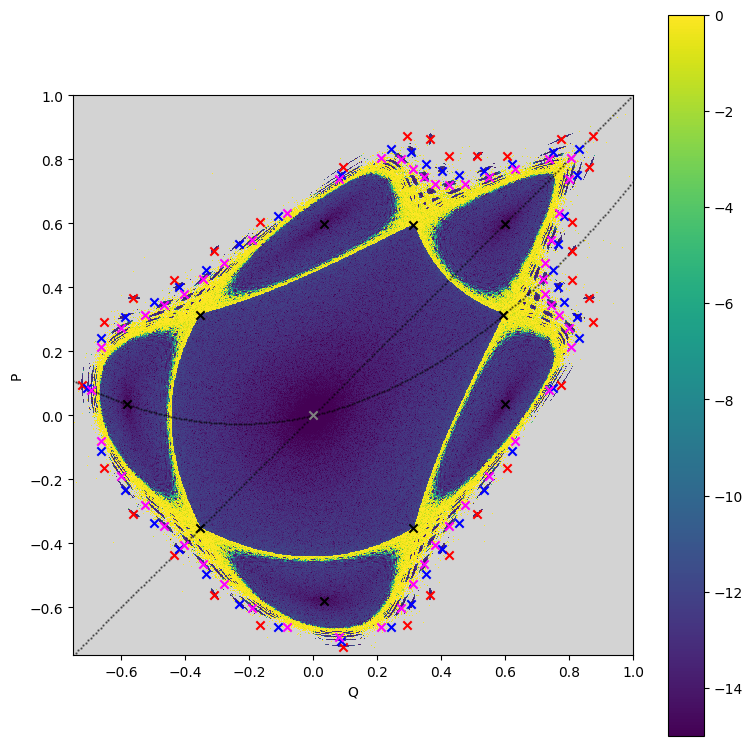

In [12]:
# Plot fixed point chains
# Note, first order hp not in range

plt.figure(figsize=(8, 8))
plt.scatter(*xs.T, color='black', s=0.5, alpha=0.5)
for chains, color in zip(table_chains, ['gray', 'black', 'red', 'blue', 'magenta']):
    plt.scatter(*chains.T, color=color, marker='x')
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1.0, -0.75, 1.0))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()

In [13]:
# For search range, each order contains two chains of fixed points (stabe and unstable)
# In what follows, unstable point is selected and corresponding manifolds are constructed
# Manifolds from different order fixed points form a tangle (complex structure in phase space)

for points in table_points:
    print(points)

[[0.   0.  ]
 [1.54 1.54]]
[[ 0.59537648  0.31417317]
 [ 0.03531505 -0.58146848]]
[[-0.43525506 -0.43525506]
 [ 0.80975282  0.51409296]]
[[ 0.40173206 -0.41893545]
 [-0.49698907 -0.33491584]]
[[ 0.27397474 -0.60040244]
 [-0.27847517 -0.52623815]]


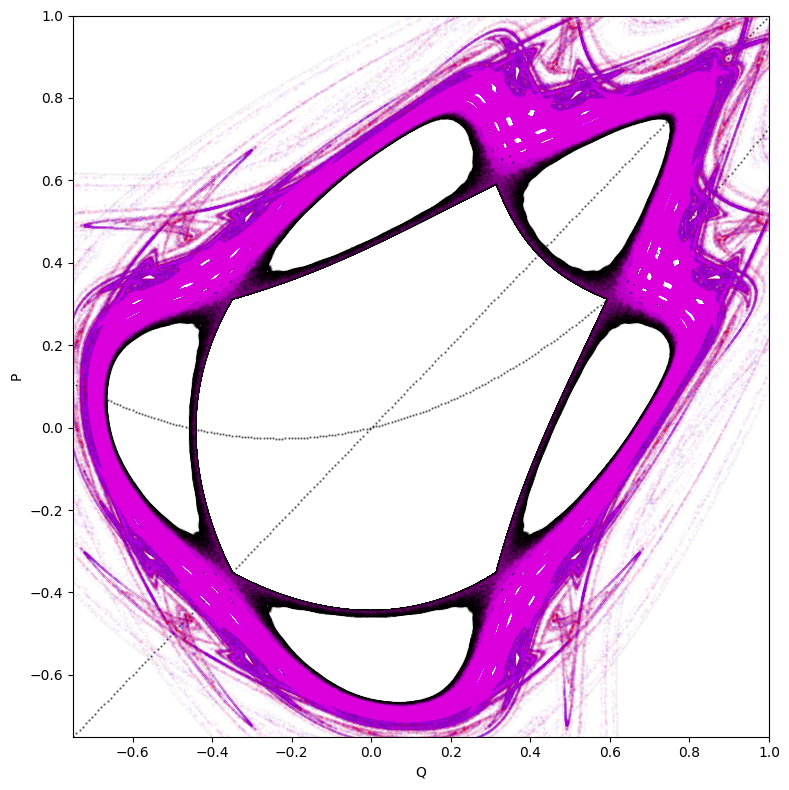

In [14]:
# Tangle formation

epsilon = 1.0E-6

size = 1024
count = 8192

plt.figure(figsize=(8, 8))
plt.scatter(*xs.T, color='black', s=0.5, alpha=0.5)

forward = jit(vmap(nest_list(count, forward2D), (0, None)))
inverse = jit(vmap(nest_list(count, inverse2D), (0, None)))

for points, order, color in zip(table_points, orders, ['gray', 'black', 'red', 'blue', 'magenta']):
    
    ms = jit(vmap(monodromy(order, forward2D), (0, None)))(points, k)
    es, vs = vmap(jax.numpy.linalg.eig)(ms)
    
    mask = classify(es)
    ph = points[~mask].squeeze()
    es = es[~mask].squeeze()
    vs = vs[~mask].squeeze()
    
    mask = manifold(es)
    ws = vs.real[mask].squeeze()
    wu = vs.real[~mask].squeeze()
    
    xu = ph + wu.real*jax.numpy.linspace(-epsilon, epsilon, size).reshape(-1, 1)
    xs = ph + ws.real*jax.numpy.linspace(-epsilon, epsilon, size).reshape(-1, 1)
    
    mu = forward(xu, k).reshape(-1, 2)
    ms = inverse(xs, k).reshape(-1, 2)

    plt.scatter(*ms.T, color=color, alpha=0.1, s=0.05)
    plt.scatter(*mu.T, color=color, alpha=0.1, s=0.05)

plt.xlabel('Q')
plt.ylabel('P')
plt.xlim(-0.75, 1.00)
plt.ylim(-0.75, 1.00)
plt.tight_layout()
plt.show()